In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [3]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

2024-02-21 14:23:25.105095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 14:23:25.105160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 14:23:25.140920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 14:23:25.223323: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-21 14:23:26.589430: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-21 14:23:27.956246: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 14:23:28.101543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-21 14:23:28.101794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
from keras.callbacks import Callback
import matplotlib.pyplot as plt

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get("mean_absolute_error"))
        self.val_losses.append(logs.get("val_mean_absolute_error"))

        plt.clf()
        plt.plot(self.x, self.losses, label="mean_absolute_error")
        plt.plot(self.x, self.val_losses, label="val_mean_absolute_error")
        plt.legend()
        plt.pause(0.01)

In [5]:
import pandas as pd

DATAPATH = "data"

d_csv = pd.read_csv(f"{DATAPATH}/fried_noodles_dataset.csv")
d_csv

,filename,meat,veggie,noodle
0,0-food_tray-10-top.jpg,0,0,0
1,0-food_tray-12-top.jpg,0,0,0
2,0-food_tray-13-top.jpg,0,0,0
3,0-food_tray-14-top.jpg,0,0,0
4,0-food_tray-16-top.jpg,0,0,0
...,...,...,...,...
1851,2020_09_18-266-top.jpg,15,15,60
1852,2020_09_18-267-top.jpg,15,15,60
1853,2020_09_18-268-top.jpg,15,15,60
1854,2020_09_18-269-top.jpg,15,15,60


In [69]:
from sklearn.model_selection import train_test_split

train_set, validation_set = train_test_split(d_csv, train_size=0.8)

In [70]:
# COPY THE ROW ON TRAINING SET, TO MAKE THE NETWORK SEE THE SAME DISTRIBUTION OF DATA
selected_rows = (train_set[train_set['meat'] > 20]).copy()
selected_rows = pd.concat([selected_rows, selected_rows, selected_rows, selected_rows], ignore_index=True)

#train_set = pd.concat([train_set, selected_rows], ignore_index=True)
#selected_rows
train_set['meat'].mean()

7.57345013477089

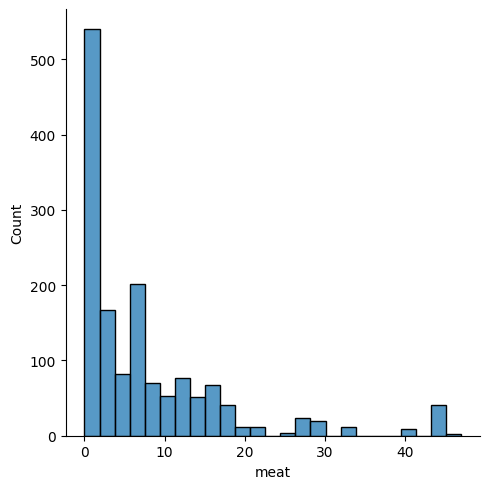

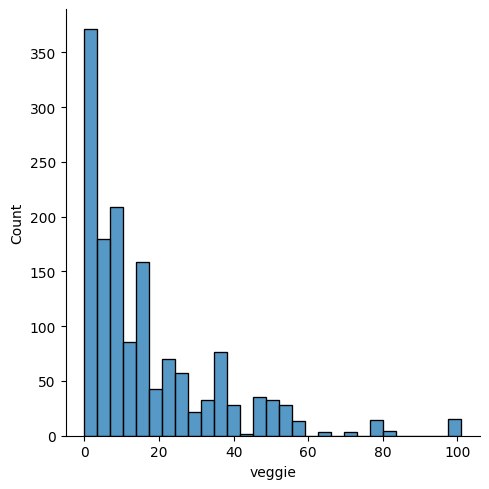

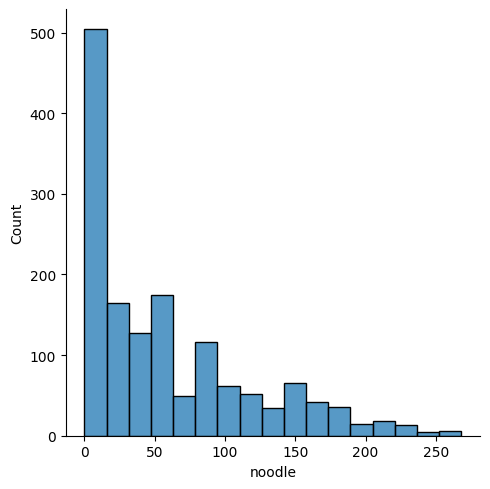

In [71]:
import seaborn as sns
sns.displot(train_set, x="meat")
sns.displot(train_set, x="veggie")
sns.displot(train_set, x="noodle")

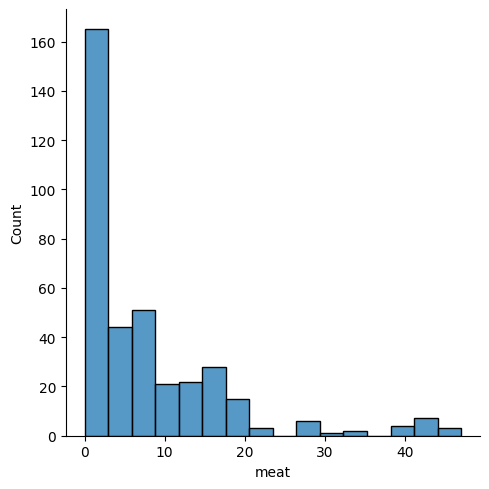

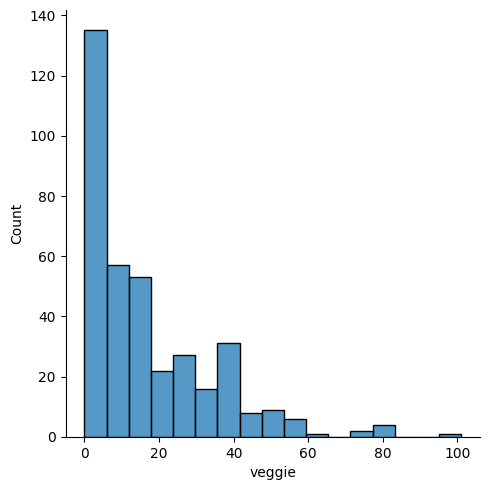

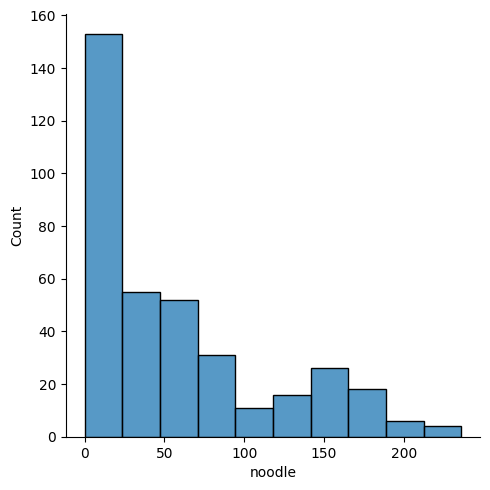

In [72]:
sns.displot(validation_set, x="meat")
sns.displot(validation_set, x="veggie")
sns.displot(validation_set, x="noodle")

ref1: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
ref2: https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow
and mucmore

prepare data, 


1. read train_set
2. use ImageGenerator to preprocess the image
4. train the model using the result from the image
5. evaluate on validation_set

In [73]:
from keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img,
)

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(
    train_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    target_size=(150, 200),
)

test_dategen = ImageDataGenerator(rescale=1.0 / 255)

validation_generator = train_datagen.flow_from_dataframe(
    validation_set,
    directory=f"{DATAPATH}/images/",
    x_col="filename",
    y_col=["meat", "veggie", "noodle"],
    class_mode="other",
    shuffle=False,
    target_size=(150, 200),
)

Found 1484 validated image filenames.
Found 372 validated image filenames.


In [84]:
import keras
from keras.models import Model
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    BatchNormalization,
    Conv2D,
    MaxPool2D,
)
from keras.optimizers import Adam

base_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(150, 200, 3),
    include_top=False
)
base_model.trainable = False

input = Input(
    shape=(
        150,
        200,
        3,
    )
)
x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
dense = Dense(512)(x)
dense = Dense(256)(dense)
dense = Dense(128)(dense)
output = keras.layers.Dense(3)(dense)

model = Model(inputs=input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mean_absolute_error"]
)
model.summary(show_trainable=True)

Model: "model_3"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_8 (InputLayer)        [(None, 150, 200, 3)]     0         Y          
                                                                            
 resnet50 (Functional)       (None, 5, 7, 2048)        2358771   N          
                                                       2                    
                                                                            
 global_average_pooling2d_3  (None, 2048)              0         Y          
  (GlobalAveragePooling2D)                                                  
                                                                            
 dense_3 (Dense)             (None, 512)               1049088   Y          
                                                                            
 dense_4 (Dense)             (None, 256)               1313

In [85]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "first_food.keras",
    verbose=1,
    monitor="val_mean_absolute_error",
    save_best_only=True,
    mode="min",
)
plot_losses = PlotLosses()

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1704.1830 - mean_absolute_error: 24.3445
Epoch 1: val_mean_absolute_error improved from inf to 23.67586, saving model to first_food.keras


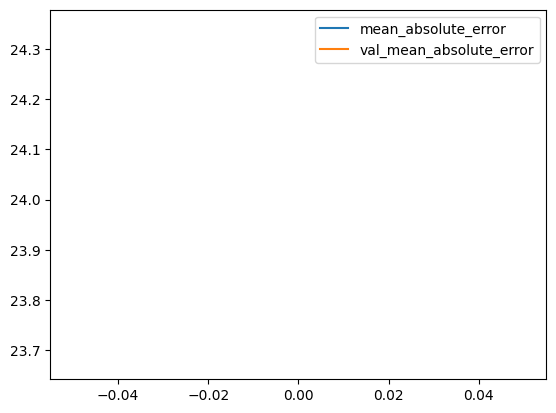

47/47 [==============================] - 10s 142ms/step - loss: 1704.1830 - mean_absolute_error: 24.3445 - val_loss: 1323.5424 - val_mean_absolute_error: 23.6759
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 1398.5579 - mean_absolute_error: 23.7638
Epoch 2: val_mean_absolute_error did not improve from 23.67586


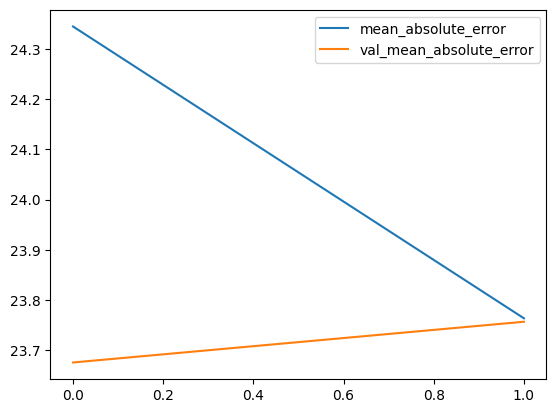

47/47 [==============================] - 5s 95ms/step - loss: 1398.5579 - mean_absolute_error: 23.7638 - val_loss: 1320.5688 - val_mean_absolute_error: 23.7569
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 1393.1005 - mean_absolute_error: 23.6439
Epoch 3: val_mean_absolute_error improved from 23.67586 to 22.98896, saving model to first_food.keras


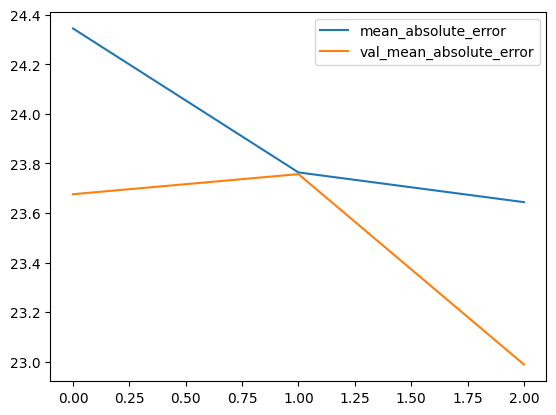

47/47 [==============================] - 6s 119ms/step - loss: 1393.1005 - mean_absolute_error: 23.6439 - val_loss: 1311.8577 - val_mean_absolute_error: 22.9890
Epoch 4/10
47/47 [==============================] - ETA: 0s - loss: 1394.3546 - mean_absolute_error: 23.6483
Epoch 4: val_mean_absolute_error did not improve from 22.98896


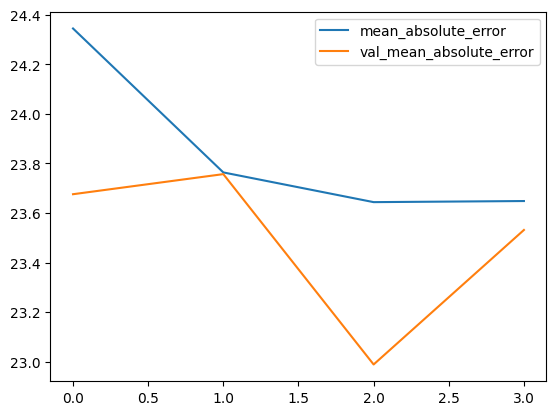

47/47 [==============================] - 4s 95ms/step - loss: 1394.3546 - mean_absolute_error: 23.6483 - val_loss: 1312.2291 - val_mean_absolute_error: 23.5316
Epoch 5/10
47/47 [==============================] - ETA: 0s - loss: 1389.9026 - mean_absolute_error: 23.7464
Epoch 5: val_mean_absolute_error did not improve from 22.98896


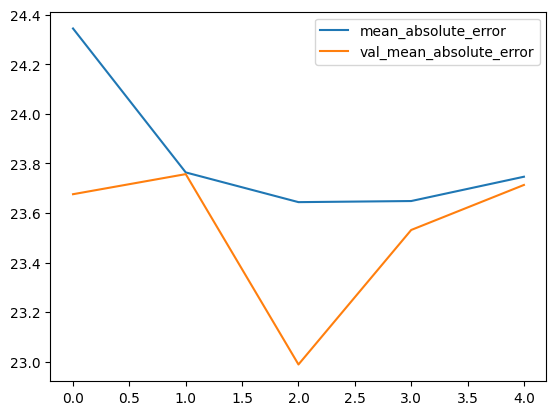

47/47 [==============================] - 5s 96ms/step - loss: 1389.9026 - mean_absolute_error: 23.7464 - val_loss: 1300.0520 - val_mean_absolute_error: 23.7132
Epoch 6/10
47/47 [==============================] - ETA: 0s - loss: 1371.5891 - mean_absolute_error: 23.5234
Epoch 6: val_mean_absolute_error improved from 22.98896 to 22.75202, saving model to first_food.keras


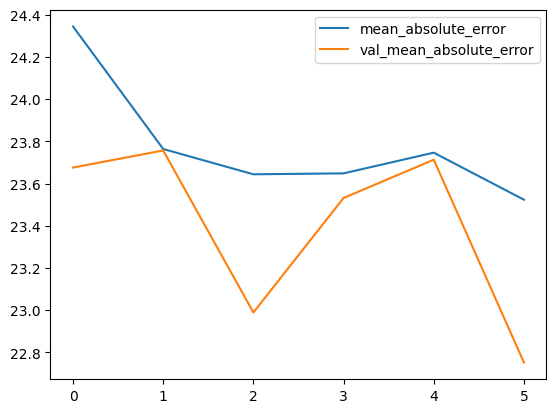

47/47 [==============================] - 6s 120ms/step - loss: 1371.5891 - mean_absolute_error: 23.5234 - val_loss: 1291.5325 - val_mean_absolute_error: 22.7520
Epoch 7/10
47/47 [==============================] - ETA: 0s - loss: 1373.8286 - mean_absolute_error: 23.6009
Epoch 7: val_mean_absolute_error did not improve from 22.75202


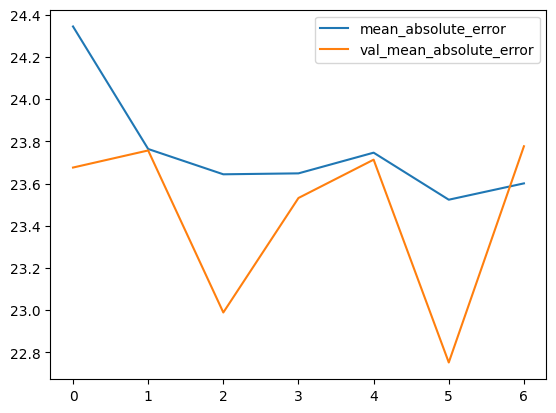

47/47 [==============================] - 5s 102ms/step - loss: 1373.8286 - mean_absolute_error: 23.6009 - val_loss: 1284.6685 - val_mean_absolute_error: 23.7768
Epoch 8/10
47/47 [==============================] - ETA: 0s - loss: 1374.0906 - mean_absolute_error: 23.3499
Epoch 8: val_mean_absolute_error did not improve from 22.75202


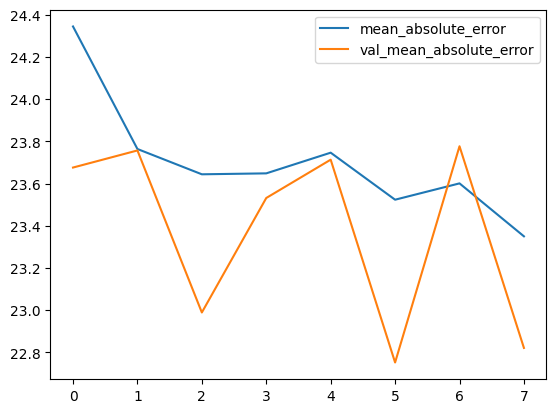

47/47 [==============================] - 5s 98ms/step - loss: 1374.0906 - mean_absolute_error: 23.3499 - val_loss: 1272.9275 - val_mean_absolute_error: 22.8210
Epoch 9/10
47/47 [==============================] - ETA: 0s - loss: 1349.8004 - mean_absolute_error: 23.5025
Epoch 9: val_mean_absolute_error did not improve from 22.75202


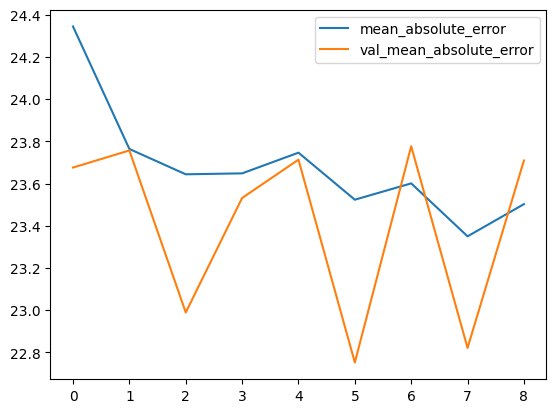

47/47 [==============================] - 5s 100ms/step - loss: 1349.8004 - mean_absolute_error: 23.5025 - val_loss: 1275.6300 - val_mean_absolute_error: 23.7090
Epoch 10/10
47/47 [==============================] - ETA: 0s - loss: 1341.6993 - mean_absolute_error: 23.2504
Epoch 10: val_mean_absolute_error did not improve from 22.75202


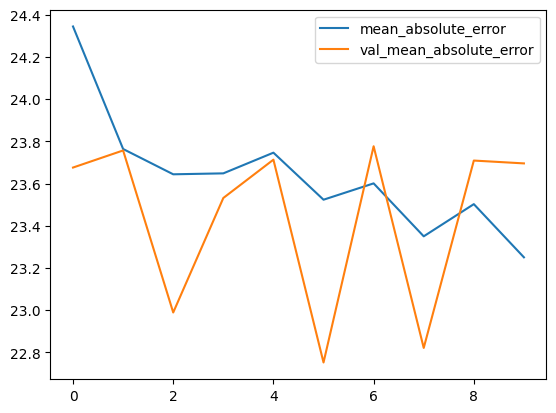

47/47 [==============================] - 5s 96ms/step - loss: 1341.6993 - mean_absolute_error: 23.2504 - val_loss: 1268.6055 - val_mean_absolute_error: 23.6955


In [86]:
# Train the Model
model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, plot_losses],
)

In [87]:
from keras.models import load_model
# Test Model
model = load_model('first_food.keras')
score = model.evaluate(
    x=validation_generator,
    steps=len(validation_generator))
print('score (mse, mae):\n',score)

12/12 [==============================] - 2s 78ms/step - loss: 1287.5428 - mean_absolute_error: 22.7490
score (mse, mae):
 [1287.5428466796875, 22.749008178710938]


In [88]:
validation_generator.reset()
predict = model.predict(
    x=validation_generator,
    steps=len(validation_generator),
    workers = 1,
    use_multiprocessing=False)
print('prediction:\n',predict)

12/12 [==============================] - 2s 76ms/step
prediction:
 [[ 7.3838596 15.829689  49.982018 ]
 [ 6.886996  15.564975  47.74159  ]
 [ 7.210311  16.000277  49.589653 ]
 ...
 [ 7.346623  16.158072  50.92145  ]
 [ 8.328321  15.424765  56.46518  ]
 [ 8.010865  16.183569  56.334106 ]]


In [89]:
val_set = validation_set.copy()

val_set['meat'] = predict[:, 0]
val_set['veggie'] = predict[:, 1]
val_set['noodle'] = predict[:, 2]

In [90]:
val_set.compare(validation_set)

meat           veggie           noodle      
          self other       self other       self other
1483  7.383860     0  15.829689    49  49.982018    34
1731  6.886996     2  15.564975     0  47.741589     0
1682  7.210311     0  16.000277    28  49.589653     0
1576  7.185077     0  15.825880     0  49.470032   107
1817  7.146113    11  16.076441     0  49.932049    89
...        ...   ...        ...   ...        ...   ...
856   8.076311    16  15.314421     0  54.078079    10
1254  7.550206     6  15.540103    15  51.702751    11
1517  7.346623     0  16.158072    46  50.921452    93
682   8.328321     0  15.424765    23  56.465179    26
728   8.010865     2  16.183569    37  56.334106    54

[372 rows x 6 columns]

In [91]:
(val_set['meat'] - validation_set['meat']).abs().mean()

7.345516524007244

In [92]:
(val_set['veggie'] - validation_set['veggie']).abs().mean()

13.699869345593196

In [93]:
(val_set['noodle'] - validation_set['noodle']).abs().mean()

47.292311678650556